## *ASF1A* and *COPS7B* gene loss in tumour samples

*ASF1A* and *COPS7B* CNA (Copy-number Alterations) data downloaded from cBioPortal  
ASF1A: https://www.cbioportal.org/results/download?case_set_id=all&gene_list=ASF1A&cancer_study_list=5c8a7d55e4b046111fee2296  
COPS7B: https://www.cbioportal.org/results/download?case_set_id=all&gene_list=COPS7B&cancer_study_list=5c8a7d55e4b046111fee2296

TCGA study abbreviations from: https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)

file_cops7b_loss = get_data_path(['cBioPortal','TCGA_PanCancer'], 'COPS7B_CNA.txt')
file_asf1a_loss = get_data_path(['cBioPortal','TCGA_PanCancer'], 'ASF1A_CNA.txt')
file_tcga_study_codes = get_data_path(['cBioPortal','TCGA_PanCancer'], 'tcga_study_abbreviations.txt')

In [2]:
study_codes = pd.read_csv(file_tcga_study_codes, sep='\t')
print('N studies:', study_codes.shape[0])
# Add code for Colorectal Adenocarcinoma
study_codes.loc[37] = ['COADREAD','Colorectal Adenocarcinoma']
study_codes[:1]

N studies: 37


,Study Abbreviation,Study Name
0,LAML,Acute Myeloid Leukemia


In [3]:
cops7b_loss = pd.read_csv(file_cops7b_loss, sep='\t')
cops7b_loss['Study Abbreviation'] = cops7b_loss['STUDY_ID'].apply(lambda x: x.split('_')[0].upper())
cops7b_loss = pd.merge(cops7b_loss, study_codes)
calc_gene_loss_percent = lambda x: sum(x=="-2")/x.count()*100
cops7b_loss = cops7b_loss.groupby(['Study Abbreviation','Study Name']).agg({'COPS7B':calc_gene_loss_percent}).reset_index()
cops7b_loss.sort_values('COPS7B', ascending=False)[:2]

,Study Abbreviation,Study Name,COPS7B
23,SARC,Sarcoma,5.490196
14,LGG,Brain Lower Grade Glioma,2.529183


In [4]:
asf1a_loss = pd.read_csv(file_asf1a_loss, sep='\t')
asf1a_loss['Study Abbreviation'] = asf1a_loss['STUDY_ID'].apply(lambda x: x.split('_')[0].upper())
asf1a_loss = pd.merge(asf1a_loss, study_codes)
asf1a_loss = asf1a_loss.groupby(['Study Abbreviation','Study Name']).agg({'ASF1A':calc_gene_loss_percent}).reset_index()
asf1a_loss.sort_values('ASF1A', ascending=False)[:4]

,Study Abbreviation,Study Name,ASF1A
6,DLBC,Lymphoid Neoplasm Diffuse Large B-cell Lymphoma,10.416667
22,PRAD,Prostate adenocarcinoma,6.275304
31,UVM,Uveal Melanoma,6.250000
1,BLCA,Bladder Urothelial Carcinoma,1.459854


In [5]:
# Cancer types in which COPS7B/ASF1A are deleted in >5% of samples
df = pd.concat([cops7b_loss[cops7b_loss.COPS7B>=5], asf1a_loss[asf1a_loss.ASF1A>=5]])
df = pd.melt(df, id_vars=['Study Abbreviation','Study Name'], var_name='gene', value_name='deletion').dropna()
df

,Study Abbreviation,Study Name,gene,deletion
0,SARC,Sarcoma,COPS7B,5.490196
5,DLBC,Lymphoid Neoplasm Diffuse Large B-cell Lymphoma,ASF1A,10.416667
6,PRAD,Prostate adenocarcinoma,ASF1A,6.275304
7,UVM,Uveal Melanoma,ASF1A,6.250000


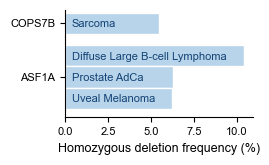

In [19]:
f, ax = plt.subplots(2, 1, figsize=(2.7,1.72), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
ax = ax.flatten()

def draw_bars(df, ax):
    sns.barplot(y='gene', x='deletion', hue='Study Name', data=df, ax=ax, palette=["#b7d4ea"],
                saturation=1, edgecolor='white', lw=1)
    ax.legend().remove()
    
draw_bars(df[df.gene=='COPS7B'],ax[0])
draw_bars(df[df.gene=='ASF1A'],ax[1])
gp.set_axis_props(ax[0], show_xticks=False, xlabel='', ylabel='', show_xaxis=False)
gp.set_axis_props(ax[1], ylabel='', xlabel='Homozygous deletion frequency (%)')

# Annotate the bars with the cancer type
c = '#144375'
ax[0].text(0.4, 0.04, 'Sarcoma', fontsize=8, va='center', color=c)
ax[1].text(0.4, -0.25, 'Diffuse Large B-cell Lymphoma', fontsize=8, va='center', color=c)
ax[1].text(0.4, 0.015, 'Prostate AdCa', fontsize=8, va='center', color=c)
ax[1].text(0.4, 0.275, 'Uveal Melanoma', fontsize=8, va='center', color=c)
plt.tight_layout(h_pad=0)

f.savefig("../figures/for_paper/del_freq.svg", bbox_inches="tight", dpi=300)